In [1]:
import os
import unicodedata

from dotenv import load_dotenv
import pandas as pd
from sqlalchemy import create_engine
import numpy as np

from recommender.read_db import ReadDatabase
from recommender.preprocess import SetUpDataframes

In [2]:
def strip_accents_lower(text):

    try:
        text = unicode(text, 'utf-8')
    except NameError: # unicode is a default on python 3 
        pass

    text = unicodedata.normalize('NFD', text)\
           .encode('ascii', 'ignore')\
           .decode("utf-8")

    return str(text).lower()

In [3]:
#dotenv_path = os.path.join(os.path.dirname(__file__), '.env')
load_dotenv('.env')

DB_URI = os.environ.get("DB_URI")
engine = create_engine(DB_URI)

reader = ReadDatabase(engine, 'CM_BD')

In [4]:
response_score_df = reader.get_data('response, value, question_id', 'posts_questionresponse', None)
response_score_df['response_normalized'] = response_score_df['response'].apply(strip_accents_lower)

----------------------------------------------------------------------
reading columns response, value, question_id from table posts_questionresponse from database CM_BD


In [5]:
responses_df = reader.get_data('user_id, response, question_id', 'posts_response', None)
responses_df = responses_df.drop_duplicates().reset_index(drop=True)
responses_df['response_normalized'] = responses_df['response'].apply(strip_accents_lower)

----------------------------------------------------------------------
reading columns user_id, response, question_id from table posts_response from database CM_BD


In [44]:
by_question_id = responses_df.groupby(['question_id', 'valid_normalized']).sum()

In [48]:
by_question_id[by_question_id['valid'] == 0.]

user_id  valid
question_id valid_normalized                
3           False              299475    0.0
4           False             1189830    0.0
5           False               47519    0.0
6           False              104421    0.0
            True                35465    0.0
...                               ...    ...
443         False              663369    0.0
444         False             1969842    0.0
445         False             1831518    0.0
446         False             2078497    0.0
447         False               45952    0.0

[386 rows x 2 columns]

In [28]:
question_ids = sorted(response_score_df['question_id'].unique())
question_with_responses = sorted(responses_df['question_id'].unique())

In [29]:
len(question_ids)

346

In [32]:
list(set(question_with_responses) - set(question_ids))

[129,
 130,
 131,
 132,
 257,
 10,
 270,
 16,
 149,
 23,
 31,
 35,
 36,
 38,
 52,
 53,
 181,
 188,
 189,
 190,
 191,
 64,
 193,
 67,
 197,
 199,
 202,
 210,
 211,
 213,
 216,
 217,
 90,
 218,
 97,
 112,
 115,
 117,
 127]

In [9]:
question_responses = response_score_df.groupby('question_id')

In [14]:
question_responses.get_group(3)

,response,value,question_id
746,lo haremos despues,0,3
1444,no lo repitio,1,3
1445,por pocas partes,2,3
1446,por algunas partes,3,3
1447,si lo repitio,4,3


In [8]:
def is_valid_response(question_id, response, normalized):
    # if the question_id does not have registered responses in posts_questionresponse,
    # then the following filter returns an empty list
    if normalized:
        valid_responses = response_score_df[response_score_df['question_id']==question_id]['response_normalized'].unique()
    else:
        valid_responses = response_score_df[response_score_df['question_id']==question_id]['response'].unique()
    # looking for something in an empty list causes no harm
    return response in valid_responses

In [13]:
responses_df['valid'] = responses_df[
    ['response', 'question_id']
].apply(lambda row: is_valid_response(row['question_id'], row['response'], False), axis=1)
responses_df['valid_normalized'] = responses_df[
    ['response_normalized', 'question_id']
].apply(lambda row: is_valid_response(row['question_id'], row['response_normalized'], True), axis=1)

In [18]:
responses_df[(responses_df['valid']==False) & (responses_df['valid_normalized']==True)]['question_id'].unique()

array([ 42,  40,  33,  30,  11,  32,  43,  74,  70, 123, 124, 126, 134,
       125, 128,  81, 141,  17,  78,  12,  15, 105, 107,  96, 106, 102,
       101,   6,  19,  18,  55,  24,  99, 120,  66, 109, 108,  94, 100,
        26,  69, 103, 110,  71,  39, 133,  27,  54,  87, 292, 247,  25,
       273, 352, 319, 254, 203, 289, 295, 280, 250, 315, 278, 298, 347,
       328, 376, 384, 370, 310, 282, 373,  98,  51,  73, 290, 366, 285,
        80, 248, 309, 288, 283, 253, 279])

In [21]:
responses_df[(responses_df['valid_normalized']==False)]

,user_id,response,question_id,response_normalized,valid,valid_normalized
0,831,Si,9,si,False,False
1,5,No la realicé,9,no la realice,False,False
2,1311,Si,10,si,False,False
3,5,No la realicé,11,no la realice,False,False
4,5,No la realicé,3,no la realice,False,False
...,...,...,...,...,...,...
15188,379,4,348,4,False,False
15189,35181,4,240,4,False,False
15190,351,0,389,0,False,False
15191,37332,4,240,4,False,False


In [35]:
responses_df[(responses_df['response'].apply(lambda x: x.isdigit())==True)]['question_id'].unique()

array([150,   3, 308, 299, 302, 349, 304, 407, 355, 335, 398, 266, 405,
       261, 301, 408, 314, 437, 244, 443, 441, 361, 446, 379, 392, 245,
       346, 403, 118, 436, 439, 265, 363, 444, 427, 313, 343, 438, 340,
       394, 326, 305, 411, 258, 401, 374, 362, 418, 422, 323, 395, 414,
       383, 445, 333, 409, 377, 276, 263, 372, 330, 434, 430, 357, 353,
       387, 334, 329, 341, 440, 300, 307, 424, 267, 426, 256, 385, 390,
       415, 339, 382, 360, 364, 332, 406, 356, 359, 311, 428, 397, 274,
       378, 348, 423, 345, 404, 402, 435, 399, 416, 166, 268, 389, 420,
       417, 312, 336, 169, 255, 264, 421, 155, 393, 247, 139, 431, 246,
       173, 380, 391, 429, 413, 316,  94, 419, 153, 175, 297, 375, 128,
       269, 400, 396, 156, 148, 126,  86, 146, 271, 442, 143, 158, 120,
       337, 125, 432, 147, 344, 165, 161, 410, 152, 144, 145, 425, 134,
       447, 159, 133, 121, 123, 157, 163,  80,  98,  41,  27, 104, 111,
       208, 194, 321, 154, 233, 187, 206, 347, 240,  74, 286, 32

In [34]:
responses_df[(responses_df['response'].apply(lambda x: x.isdigit())==False) & (responses_df['valid']==False)]

,user_id,response,question_id,valid
0,831,si,9,False
1,5,no la realice,9,False
2,1311,si,10,False
3,5,no la realice,11,False
4,5,no la realice,3,False
...,...,...,...,...
15138,36318,si lo logra,210,False
15144,34178,un poco,257,False
15155,35586,si lo logro,218,False
15165,38499,si la realizo,217,False


,response,value,question_id


In [49]:
responses_valid_df = responses_df[responses_df['valid_normalized']==True]

In [28]:
response_score_df[response_score_df['question_id']==160]

,response,value,question_id
679,lo haremos despues,0,160
680,5,4,160
681,3,3,160
682,1,2,160
683,0,1,160


In [26]:
is_valid_response(160, '3')

True

In [24]:
print(responses_df[responses_df['question_id']==100]['response'].unique())
print(response_score_df[response_score_df['question_id']==100]['response'].unique())

['solo algunos' 'si' 'aun no la realizamos' 'si pudo' 'aun no'
 'lo haremos despues' '4']
['lo haremos despues' 'aun no' 'solo algunos' 'si pudo']


In [110]:
def response_to_score(row):
    try:
        return response_score_df[
            (response_score_df['question_id'] == row['question_id']) 
        ]
    except IndexError:
        return np.nan

In [78]:
response_to_score(responses_df.loc[1003])

,response,value,question_id
941,Lo haremos después,0,54
942,Aún no,1,54
943,Con dificultad,2,54
944,Sí con ayuda,3,54
945,Sí lo logró,4,54


In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

#matplotlib inline

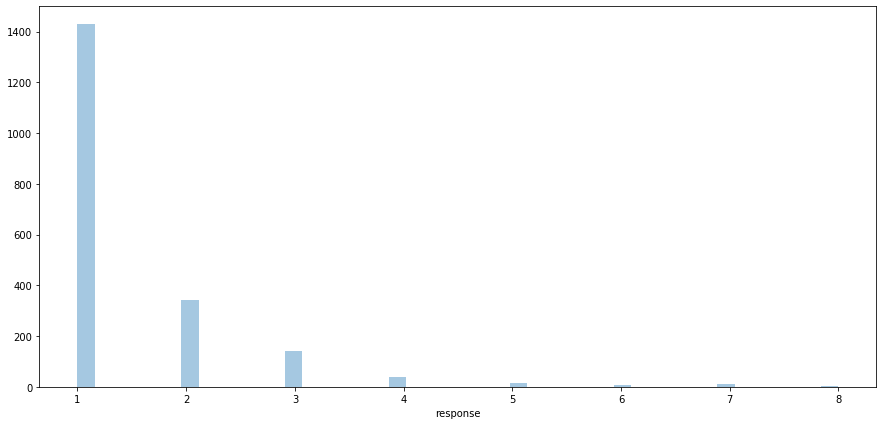

In [55]:
fig = plt.figure(figsize=(15,7))
sns.distplot(responses_valid_df.groupby('user_id').count()['response'], kde=False)

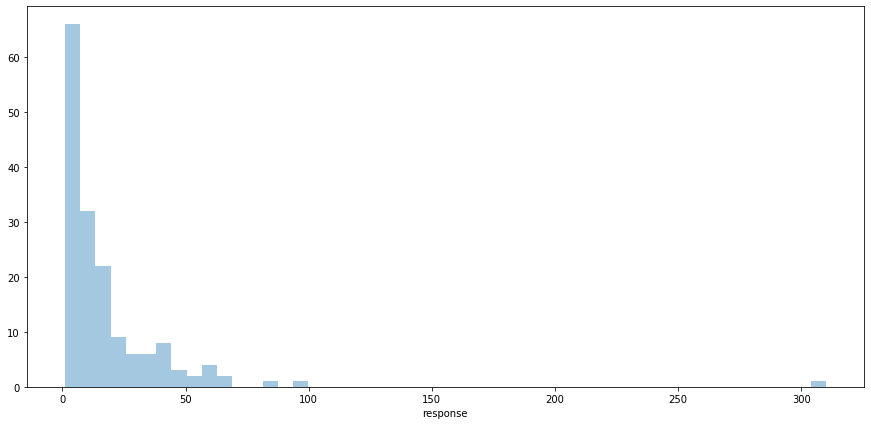

In [58]:
fig = plt.figure(figsize=(15,7))
sns.distplot(responses_valid_df.groupby('question_id').count()['response'], kde=False)